### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
from scipy.special import erf
import scipy.stats

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.core.modeling_framework import MultiCompartmentSphericalMeanModel
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models

from scipy.io import savemat

/Users/admin/opt/anaconda3/envs/project/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simulate Signal

In [2]:
def sim_sig_np(bf,be,tm,adc,sigma,axr,nvox):
    
    be_tiled = np.tile(be,(nvox,1))
    bf_tiled = np.tile(bf,(nvox,1))
    tm_tiled = np.tile(tm,(nvox,1))

    adc_tiled = np.transpose(np.tile(adc,(np.size(tm),1)))
    sigma_tiled = np.transpose(np.tile(sigma,(np.size(tm),1)))
    axr_tiled = np.transpose(np.tile(axr,(np.size(tm),1)))

    tm_tiled[(tm_tiled == np.min(tm_tiled)) & (bf_tiled == 0)] = np.inf

    adc_prime_tiled = adc_tiled * (1 - sigma_tiled* np.exp(-tm_tiled*axr_tiled))
    normalised_signal_tiled = np.exp(-adc_prime_tiled * be_tiled)
    
    return normalised_signal_tiled, adc_prime_tiled


In [3]:
def sim_sig_pytorch(bf, be, tm, adc_tiled, sigma_tiled, axr_tiled, batch_size):
    """batch_size and nvox are kind of interchangable
    might be useful to know for testing purposes
    """
    be_tiled = torch.tile(be,(batch_size,1))
    bf_tiled = torch.tile(bf,(batch_size,1))
    tm_tiled = torch.tile(tm,(batch_size,1))

    """
    use this section for testing if function works as intended    
    adc_tiled = torch.tile(adc,(tm.shape[0],1)).t()
    sigma_tiled = torch.tile(sigma,(tm.shape[0],1)).t()
    axr_tiled = torch.tile(axr,(tm.shape[0],1)).t()
    """

    tm_tiled[(tm_tiled == torch.min(tm_tiled)) & (bf_tiled == 0)] = float('inf')
    

    adc_prime_tiled = adc_tiled * (1 - sigma_tiled * torch.exp(-tm_tiled * axr_tiled))
    normalised_signal_tiled = torch.exp(-adc_prime_tiled * be_tiled)

    return normalised_signal_tiled, adc_prime_tiled

### Initial variables.

In [4]:
nvox = 100000 # number of voxels to simulate

bf = np.array([0, 0, 250, 250, 250, 250, 250, 250]) * 1e-3   # filter b-values [ms/um2]
be = np.array([0, 250, 0, 250, 0, 250, 0, 250]) * 1e-3       # encoding b-values [ms/um2]
tm = np.array([20, 20, 20, 20, 200, 200, 400, 400], dtype=np.float32)  # mixing time [ms]

adc_lb = 0.1        #[um2/ms]
adc_ub = 3.5        #[um2/ms]
sig_lb = 0          #[a.u.]
sig_ub = 1          #[a.u.]
axr_lb = 0.1 * 1e-3 #[ms-1]
axr_ub = 20 * 1e-3  #[ms-1]
#consider doing in si units

limits = np.array([[adc_lb, adc_ub], [sig_lb, sig_ub] , [axr_lb, axr_ub]])

adc_init = 1.1      #[um2/ms]
sig_init = 0.15     #[a.u.]
axr_init = 3.5      #[ms-1]

#consider doing in si units
inits = np.array([adc_init,sig_init,axr_init])

sim_adc = np.random.uniform(adc_lb,adc_ub,nvox)                 # ADC, simulated [um2/ms]
sim_sigma = np.random.uniform(sig_lb,sig_ub,nvox)               # sigma, simulated [a.u.]
sim_axr = np.random.uniform(axr_lb,axr_ub,nvox)                 # AXR, simulated [ms-1]

sim_E_vox, sim_adc_prime = sim_sig_np(bf,be,tm,sim_adc,sim_sigma,sim_axr,nvox)

In [5]:
"""sim_adc1 = torch.tensor(sim_adc)
sim_sigma1 = torch.tensor(sim_sigma)
sim_axr1 = torch.tensor(sim_axr)
be = torch.tensor(be)
bf = torch.tensor(bf)
tm = torch.tensor(tm)

sim_E_vox1, sim_adc_prime1 = sim_sig_pytorch(bf,be,tm,sim_adc1,sim_sigma1,sim_axr1,nvox)"""

'sim_adc1 = torch.tensor(sim_adc)\nsim_sigma1 = torch.tensor(sim_sigma)\nsim_axr1 = torch.tensor(sim_axr)\nbe = torch.tensor(be)\nbf = torch.tensor(bf)\ntm = torch.tensor(tm)\n\nsim_E_vox1, sim_adc_prime1 = sim_sig_pytorch(bf,be,tm,sim_adc1,sim_sigma1,sim_axr1,nvox)'

### Histogram plots

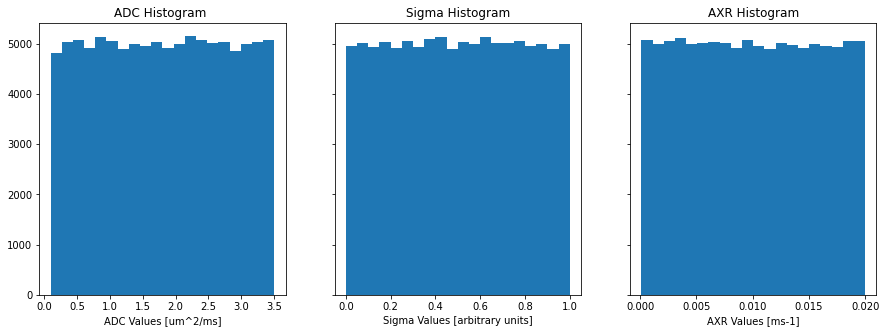

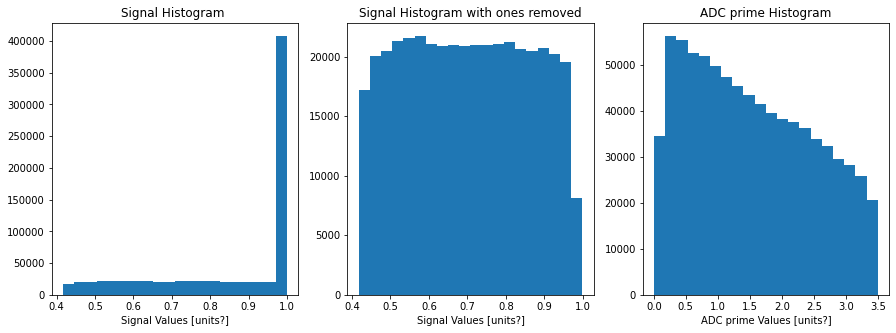

In [6]:
n_bins=20
#make 200 and voxels 100,000 to see adc prime dropoff
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(15, 5))
axs[0].hist(sim_adc, bins=n_bins)
axs[1].hist(sim_sigma, bins=n_bins)
axs[2].hist(sim_axr, bins=n_bins)
axs[0].set_title('ADC Histogram ')
axs[0].set_xlabel('ADC Values [um^2/ms]')
axs[1].set_title('Sigma Histogram')
axs[1].set_xlabel('Sigma Values [arbitrary units]')
axs[2].set_title('AXR Histogram')
axs[2].set_xlabel('AXR Values [ms-1]');


fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].hist(sim_E_vox.flatten(), bins=n_bins)
axs[0].set_title('Signal Histogram ')
axs[0].set_xlabel('Signal Values [units?]')
axs[1].hist(sim_E_vox[sim_E_vox != 1].flatten(), bins=n_bins)
axs[1].set_title('Signal Histogram with ones removed')
axs[1].set_xlabel('Signal Values [units?]')
axs[2].hist(sim_adc_prime.flatten(), bins=n_bins)
axs[2].set_title('ADC prime Histogram')
axs[2].set_xlabel('ADC prime Values [units?]');


### Plotting b-value against normalised signal

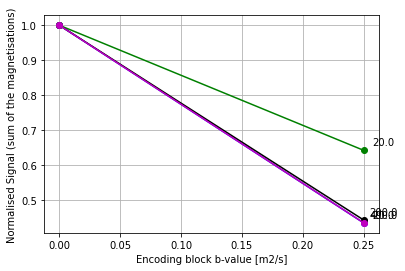

In [7]:
plt.plot([be[0], be[1]], [sim_E_vox[0,0], sim_E_vox[0,1]], 'bo-')
plt.annotate(tm[0], (be[1], sim_E_vox[0, 1]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[2], be[3]], [sim_E_vox[0,2], sim_E_vox[0,3]], 'go-')
plt.annotate(tm[2], (be[3], sim_E_vox[0, 3]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[4], be[5]], [sim_E_vox[0,4], sim_E_vox[0,5]], 'ko-')
plt.annotate(tm[4], (be[5], sim_E_vox[0, 5]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[6], be[7]], [sim_E_vox[0,6], sim_E_vox[0,7]], 'mo-')
plt.annotate(tm[6], (be[7], sim_E_vox[0, 7]), textcoords="offset points", xytext=(20,5), ha='center')


#plt.title('Scatter plot with 4 lines')
plt.xlabel('Encoding block b-value [m2/s]')
#are units correct
plt.ylabel('Normalised Signal (sum of the magnetisations)')
#unit?
plt.grid(True)
plt.show()


### Least squares fit
Everything has a 1 suffix for testing the least squares fit.


In [17]:
nvox1 = 2
bf1 = np.array([0, 0, 250, 250, 250, 250, 250, 250]) * 1e-3   # filter b-values [ms/um2]
be1 = np.array([0, 250, 0, 250, 0, 250, 0, 250]) * 1e-3       # encoding b-values [ms/um2]
tm1 = np.array([20, 20, 20, 20, 200, 200, 400, 400], dtype=np.float32)  # mixing time [ms]

sim_adc1 = np.random.uniform(adc_lb,adc_ub,nvox1)                 # ADC, simulated [um2/ms]
sim_sigma1 = np.random.uniform(sig_lb,sig_ub,nvox1)               # sigma, simulated [a.u.]
sim_axr1 = np.random.uniform(axr_lb,axr_ub,nvox1)                 # AXR, simulated [ms-1]

"""sim_adc1 = np.array([1.25])
sim_sigma1 = np.array([0.125])
sim_axr1 = np.array([3.25])"""

sim_E_vox1, sim_adc_prime1 = sim_sig_np(bf1,be1,tm1,sim_adc1,sim_sigma1,sim_axr1,nvox1)

def sse_adc_prime(variables_to_optimize, tm1, bf1, be1, sim_E_vox1):
    sm_meas = sim_E_vox1
    adc_est1,sigma_est1,axr_est1 = variables_to_optimize
    _ , adc_tm_fit1 = sim_sig_np(bf1,be1,tm1,adc_est1,sigma_est1,axr_est1,nvox1)

    bf_tm1 = np.column_stack((bf1.flatten(), tm1.flatten()))

    # Find unique rows and corresponding indices
    univols, univols_indices = np.unique(bf_tm1, axis=0, return_index=True)

    nsf = univols.shape[0]
    
    binary_array1 = np.zeros_like(be1, dtype=bool)
    condition1 = (np.sum(univols[:, None, :] == bf_tm1, axis=2) == 2) & (be1 == 0)
    binary_array1[np.where(condition1)[1]] = True
    ix1 = binary_array1
    #print(ix1)
        
    binary_array2 = np.zeros_like(be1, dtype=bool)
    condition2 = (np.sum(univols[:, None, :] == bf_tm1, axis=2) == 2) & (be1 > 0)
    binary_array2[np.where(condition2)[1]] = True
    ix2 = binary_array2
    #print(ix2)

    #ix1 = np.where((np.sum(univols[:, None, :] == bf_tm1, axis=2) == 2) & (be1 == 0))[1]
    #ix2 = np.where((np.sum(univols[:, None, :] == bf_tm1, axis=2) == 2) & (be1 > 0))[1]
    
    be1_tiled = np.tile(be1,(nvox1,1))
    ix1_tiled = np.tile(ix1,(nvox1,1))
    ix2_tiled = np.tile(ix2,(nvox1,1))
    
    #print(ix1_tiled.shape)
    #print(ix2_tiled.shape)
    #print(sm_meas.shape)
    #print(be1_tiled.shape)

    adc_tm_calc1 = -1 / (be1_tiled[ix2_tiled] - be1_tiled[ix1_tiled]) * np.log(sm_meas[ix2_tiled] / sm_meas[ix1_tiled])
    
    #print("new size of calc", adc_tm_calc1.shape)

    adc_tm_fit1 = adc_tm_fit1[:, ::2]
    """adc_tm_fit1 = adc_tm_fit1.T
    adc_tm_fit1 = adc_tm_fit1[::2] # better to do in abstract fashion.
    adc_tm_fit1 = adc_tm_fit1.T"""

    #this line is hardcoded
    adc_tm_calc1 = adc_tm_calc1.reshape(nvox1,4)
    #print("new size of calc", adc_tm_calc1.shape)


    sse = np.sum((adc_tm_calc1 - adc_tm_fit1) ** 2)
    return sse
sse_adc_prime([sim_adc1, sim_axr1, sim_sigma1], tm1, bf1, be1, sim_E_vox1)


0.5571859669884285

In [23]:
#basic minimization function

# Initial guess
initial_guess = inits  # Starting values for ADC , sigma, AXR, in ms not SI units

# Define the bounds for adc, sigma, axr
bounds = tuple(map(tuple, limits.tolist())) #this line seems messy

additional_args = (tm1, bf1, be1, sim_E_vox1) 
# Minimize the function using L-BFGS-B method with bounds

result = scipy.optimize.minimize(sse_adc_prime, initial_guess, args=additional_args, bounds=bounds, method='L-BFGS-B')

# Print the result
print("True values of ADC, Sigma, AXR:", sim_adc1,sim_sigma1,sim_axr1)
print("Minimized values of ADC, Sigma, AXR:", result.x)
print("The sse at these values is", result.fun)

NLLS_adc, NLLS_sigma, NLLS_axr = result.x
NLLS_E_vox,NLLS_axr_prime = sim_sig_np(bf1,be1,tm1,NLLS_adc, NLLS_sigma, NLLS_axr,nvox1)


True values of ADC, Sigma, AXR: [3.03067164 1.21044894] [0.28241272 0.37986576] [0.01295556 0.01492162]
Minimized values of ADC, Sigma, AXR: [2.12051608 0.30971098 0.01355416]
The sse at these values is 6.0159245483414905


### NLLS Plots

ValueError: x and y must be the same size

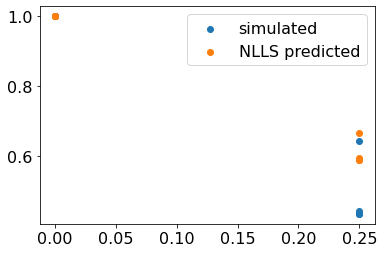

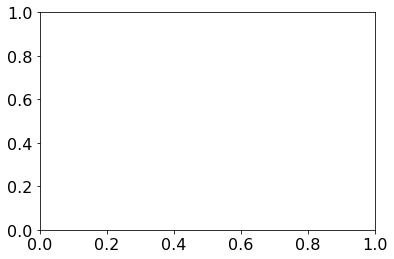

In [25]:

plt.scatter(be, sim_E_vox[0,:], label='simulated')
plt.scatter(be, NLLS_E_vox[0,:], label='NLLS predicted')
plt.legend()

# plot scatter plots to analyse correlation of predicted free params against ground truth
plt.figure()

param_sim = [sim_adc1, sim_sigma1, sim_axr1]
param_pred_NLLS = [NLLS_adc, NLLS_sigma, NLLS_axr]
param_name = ['ADC', 'Sigma', 'AXR']

rvals = []

for i,_ in enumerate(param_sim):
    plt.rcParams['font.size'] = '16'
    plt.scatter(param_sim[i], param_pred[i], s=2, c='navy')
    plt.xlabel(param_name[i] + ' Ground Truth')
    plt.ylabel(param_name[i] + ' Prediction')
    rvals.append(scipy.stats.pearsonr(np.squeeze(param_sim[i]), np.squeeze(param_pred[i])))
    plt.tight_layout
    plt.show()

print(rvals)


### Creating the neural network

In [ ]:
class Net(nn.Module): # this is the neural network
    #defining the init and foward pass functions. 

    def __init__(self,be,bf,tm,nparams,limits):
        super(Net, self).__init__()

        self.be = be
        self.bf = bf
        self.tm = tm
        self.limits = limits

        #defining the layers that we want. 
        # 3 layers with no. of be nodes. 
        self.layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.layers.extend([nn.Linear(len(be), len(be)), nn.PReLU()])
            #https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html
        self.encoder = nn.Sequential(*self.layers, nn.Linear(len(be), nparams))

    def forward(self, E_vox):

        params = torch.nn.functional.softplus(self.encoder(E_vox))
        #running a forward pass through the network

        #SoftPlus is a smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive
        #params contains batch_size x nparams outputs, so each row is adc, sigma and axr.

        #unsqueeze adds an additional dimension. 
        #parameter constraints from Elizabeth matlab 

        adc = torch.tile(torch.clamp(params[:, 0].unsqueeze(1), min=limits[0,0], max=limits[0,1]), (1, tm.shape[0]))
        sigma = torch.tile(torch.clamp(params[:, 1].unsqueeze(1), min=limits[1,0], max=limits[1,1]), (1, tm.shape[0]))
        axr = torch.tile(torch.clamp(params[:, 2].unsqueeze(1), min=limits[2,1], max=limits[2,1]), (1, tm.shape[0]))

        E_vox,_ = sim_sig_pytorch(self.bf, self.be, self.tm, adc, sigma, axr, axr.shape[0])
        #axr.shape[0] is either the batch size or nvox

        return E_vox, adc, sigma, axr


### NN continued

In [ ]:
# define network
nparams = 3
#because of adc, sigma and axr

#converting numpy arrays to pytorch tensors. 
be = torch.tensor(be)
bf = torch.tensor(bf)
tm = torch.tensor(tm)
batch_size = 128

#initilise network
net = Net(be, bf, tm, nvox, nparams, batch_size)

#create batch queues for data
#// means divide and round down. 
num_batches = len(sim_E_vox) // batch_size

#import the sim_E_vox array into the dataloader
#drop_last ignores the last batch if it is the wrong size. 
#num_workers is about performance. 

trainloader = utils.DataLoader(torch.from_numpy(sim_E_vox.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 0, #was 2 previously
                                drop_last = True)

# loss function and optimizer
#choosing which loss function to use. 
#not sure what the optmizer is
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# best loss
best = 1e16
num_bad_epochs = 0
#can increase patience a lot, speed not an issue.
patience = 10

### Training

In [ ]:
# train
loss_progress = np.empty(shape=(0,)) 
for epoch in range(10000): 
    print("-----------------------------------------------------------------")
    print("epoch: {}; bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    #tqdm shows a progress bar. 
    for i, sim_E_vox_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred_E_vox, pred_adc, pred_sigma, pred_axr = net(sim_E_vox_batch)

        sim_E_vox_batch64 = sim_E_vox_batch.to(torch.float64)
        #needed so that loss comparison works

        loss = criterion(pred_E_vox, sim_E_vox_batch64)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print("loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("####################### saving good model #######################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
        loss_progress = np.append(loss_progress, best)
    else:
        num_bad_epochs = num_bad_epochs + 1
        loss_progress = np.append(loss_progress, best)
        if num_bad_epochs == patience:
            print("done, best loss: {}".format(best))
            break
print("done")

net.load_state_dict(final_model)

net.eval()
with torch.no_grad():
    final_pred_E_vox, final_pred_adc_repeated, final_pred_sigma_repeated, final_pred_axr_repeated = net(torch.from_numpy(sim_E_vox.astype(np.float32)))
    # adc sigma and axr will have 8 columns which are all the same

final_pred_adc = final_pred_adc_repeated[:, 0]
final_pred_sigma = final_pred_sigma_repeated [:, 0]
final_pred_axr = final_pred_axr_repeated[:, 0]


### NN Plots

In [ ]:
plt.figure()
plt.plot(range(1, len(loss_progress) + 1), loss_progress, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.show()

final_pred_E_vox_detached = final_pred_E_vox.detach().numpy()
"""Was having numpy pytorch issues, so this line helps fix it a bit."""

plt.scatter(be, sim_E_vox[0,:], label='simulated')
plt.scatter(be, final_pred_E_vox_detached[0,:], label='predicted')
plt.legend()

# plot scatter plots to analyse correlation of predicted free params against ground truth
plt.figure()

param_sim = [sim_adc, sim_sigma, sim_axr]
param_pred = [final_pred_adc, final_pred_sigma, final_pred_axr]
param_name = ['ADC', 'Sigma', 'AXR']

rvals = []

for i,_ in enumerate(param_sim):
    plt.rcParams['font.size'] = '16'
    plt.scatter(param_sim[i], param_pred[i], s=2, c='navy')
    plt.xlabel(param_name[i] + ' Ground Truth')
    plt.ylabel(param_name[i] + ' Prediction')
    rvals.append(scipy.stats.pearsonr(np.squeeze(param_sim[i]), np.squeeze(param_pred[i])))
    plt.tight_layout
    plt.show()

print(rvals)
